In [1]:
import numpy as np
import torch

torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

import matplotlib as mpl

mpl.rcParams["hatch.linewidth"] = 3.0

## 9.2 Multi-fidelity modeling with Gaussian processes

### 9.2.1 Formatting a multi-fidelity data set

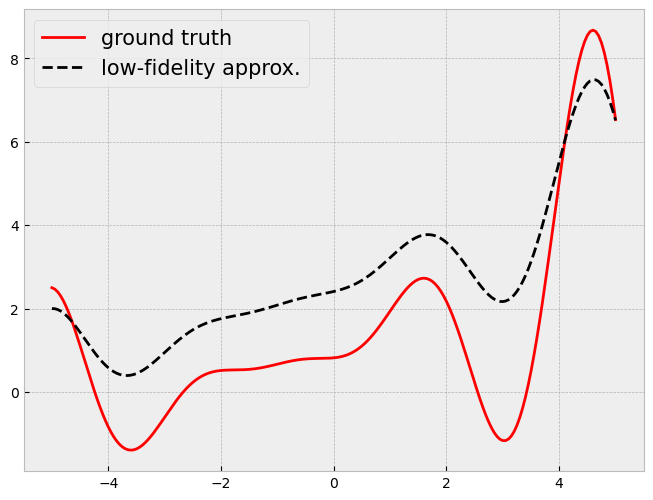

In [2]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


def approx_objective(x):
    return 0.5 * objective(x) + x / 4 + 2


def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if torch.isclose(x[-1], torch.ones(1)):
            y.append(objective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return torch.tensor(y).unsqueeze(-1)


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)
fidelities = torch.tensor([0.5, 1.0])

xs = torch.linspace(lb, ub, 201)

ys = objective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

In [3]:
n = 10

torch.manual_seed(0)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n, 1)

train_f = fidelities[torch.randint(2, (n, 1))]  # mixed fidelity
# train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity

train_x_full = torch.cat([train_x, train_f], dim=1)
train_x_full

tensor([[-0.0374,  1.0000],
        [ 2.6822,  0.5000],
        [-4.1152,  0.5000],
        [-3.6797,  1.0000],
        [-1.9258,  0.5000],
        [ 1.3408,  0.5000],
        [-0.0991,  0.5000],
        [ 3.9644,  0.5000],
        [-0.4437,  0.5000],
        [ 1.3231,  1.0000]])

In [4]:
train_y = evaluate_all_functions(train_x_full)
train_y

tensor([[ 0.8137],
        [ 2.4210],
        [ 0.7342],
        [-1.3725],
        [ 1.7799],
        [ 3.6063],
        [ 2.3797],
        [ 5.3423],
        [ 2.2874],
        [ 2.5180]])

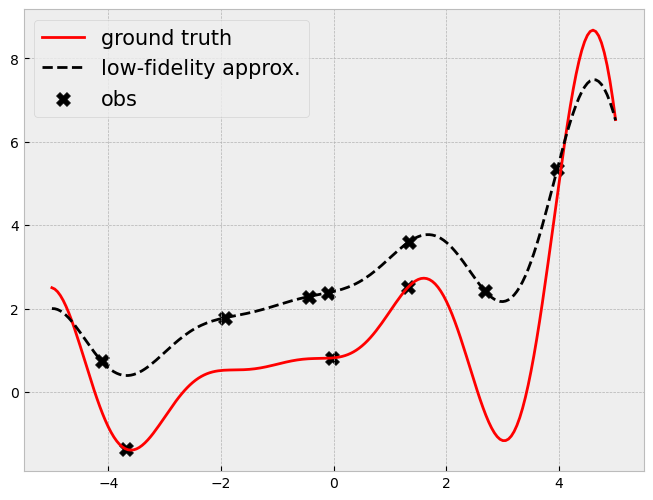

In [5]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c="k", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [6]:
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [7]:
model = SingleTaskMultiFidelityGP(train_x_full, train_y, data_fidelity=1)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll);

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [8]:
with torch.no_grad():
    pred_dist = model(torch.vstack([xs, torch.ones_like(xs)]).T)
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()

    # approx_pred_dist = model(torch.vstack([xs, torch.ones_like(xs) * 0.5]).T)
    # approx_pred_mean = approx_pred_dist.mean
    # approx_pred_lower, approx_pred_upper = approx_pred_dist.confidence_region()

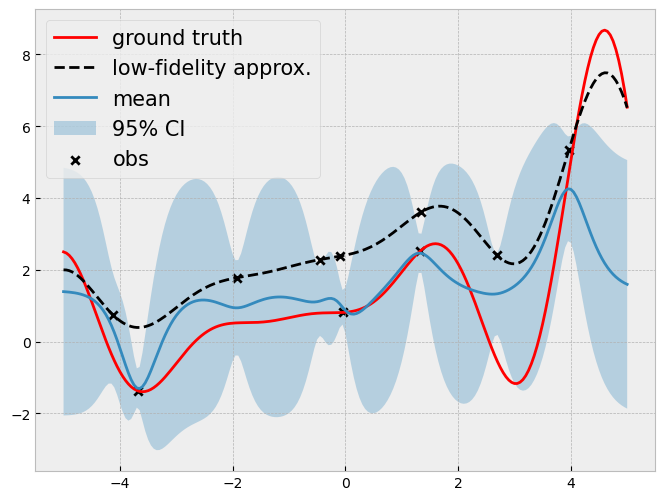

In [9]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

# plt.plot(xs, approx_pred_mean, c="orange", label="low-fidelity mean")
# plt.fill_between(
#     xs.flatten(),
#     approx_pred_lower,
#     approx_pred_upper,
#     color="orange",
#     alpha=0.3,
#     label="low-fidelity 95% CI",
# )

plt.scatter(train_x, train_y, c="k", marker="x", label="obs")

plt.legend(fontsize=15);